In [35]:
import data_preprocess_functions as dp_f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import math

In [36]:
mode='VariableCone_m/'
path='../PKL/Zprime'+mode

In [4]:
data_singleBJet=pd.read_csv(path+'singleBJet_df_m3.csv')
data_singleBTrk=pd.read_csv(path+'singleBTrk_df_m3.csv')
data_lightJet=pd.read_csv(path+'lightJet_df_m3.csv')
data_lightTrk=pd.read_csv(path+'lightTrk_df_m3.csv')


In [5]:
data_singleBTrk.shape,data_lightTrk.shape

((66058, 22), (202522, 22))

N oneB jets:  6454 . pT mean:  543827.0571245182
N oneB jets:  26928 . pT mean:  221044.57228774708


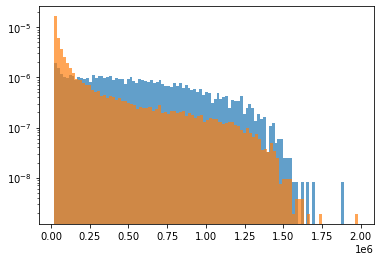

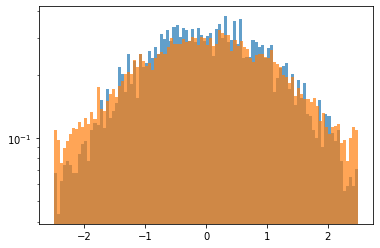

In [6]:
print('N oneB jets: ',data_singleBJet.shape[0],'. pT mean: ',data_singleBJet['pT'].mean())
print('N oneB jets: ',data_lightJet.shape[0],'. pT mean: ', data_lightJet['pT'].mean())
plt.hist(data_singleBJet['pT'],bins=100,label='singleB',density=True,alpha=0.7)
plt.hist(data_lightJet['pT'],bins=100,label='light',density=True,alpha=0.7)
plt.yscale('log')
plt.show()
plt.hist(data_singleBJet['Eta'],bins=100,label='singleB',density=True,alpha=0.7)
plt.hist(data_lightJet['Eta'],bins=100,label='light',density=True,alpha=0.7)
plt.yscale('log')
plt.show()


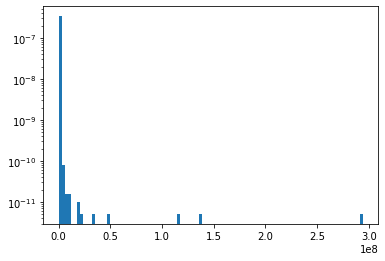

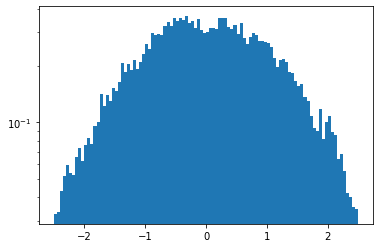

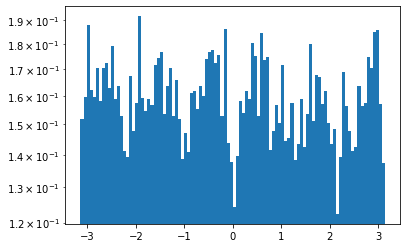

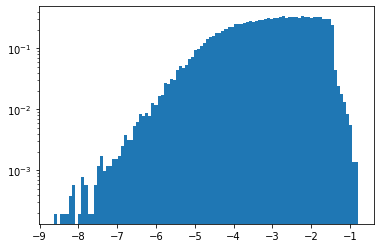

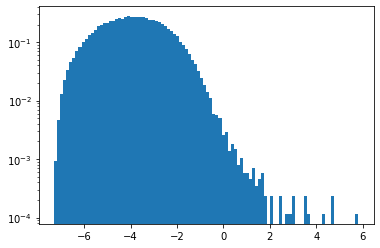

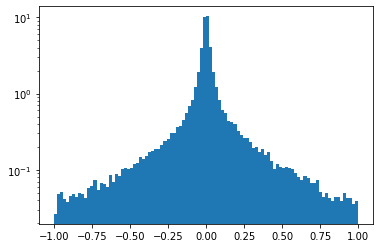

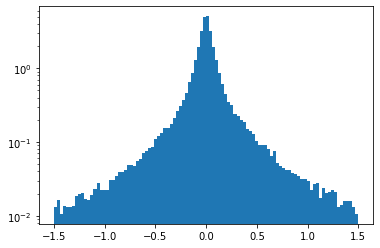

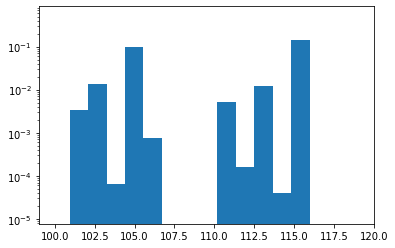

In [7]:
plt.hist(data_singleBTrk['pT'],density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['Eta'],density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['Phi'],density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['DR'].apply(lambda x: math.log(x)),density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['pTfrac'].apply(lambda x: math.log(x)),density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['trk_d0'],density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['trk_z0SinTheta'],density=True,bins=100)
plt.yscale('log')
plt.show()

plt.hist(data_singleBTrk['excl_origin'],density=True,bins=100)
plt.yscale('log')
plt.xlim([99,120])
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

def preprocess_DF(data, cut_str):
    data_cp=data.copy()
    if cut_str!='':
        data_cp=data_cp.query(cut_str)
        
    data_cp['pT']=data_cp['pT'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'pT': 'log_pt'})
    data_cp=data_cp.rename(columns={'Eta': 'eta'})
    data_cp=data_cp.rename(columns={'Phi': 'phi'})
    data_cp=data_cp.rename(columns={'Theta': 'theta'})
    data_cp['DR']=data_cp['DR'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'DR': 'log_dr'})
    data_cp['pTfrac']=data_cp['pTfrac'].apply(lambda x: math.log(x))
    data_cp=data_cp.rename(columns={'pTfrac': 'log_ptfrac'})
#    data_cp['pZfrac']=data_cp['pZfrac'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'pZfrac': 'log_pzfrac'})
    
#    data_cp['p3fracJetE']=data_cp['p3fracJetE'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'p3fracJetE': 'log_p3fracJetE'})
    data_cp.drop('p3fracJetE',axis=1,inplace=True)
#    data_cp['closestJetDR']=data_cp['closestJetDR'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'closestJetDR': 'log_closestJetDR'})
#    data_cp['closestJetDRtrkjet']=data_cp['closestJetDRtrkjet'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'closestJetDRtrkjet': 'log_closestJetDRtrkjet'})
    data_cp.drop('closestJetDRtrkjet',axis=1,inplace=True)
    data_cp.drop('closestJetDeta',axis=1,inplace=True)
    data_cp.drop('E',axis=1,inplace=True)
#    data_cp['E']=data_cp['E'].apply(lambda x: math.log(x))
#    data_cp=data_cp.rename(columns={'E': 'log_E'})
    data_cp.drop('Deta',axis=1,inplace=True)
    data_cp.drop('Dphi',axis=1,inplace=True)    
#    data_cp.drop('phi',axis=1,inplace=True)
    data_cp.drop('pZfrac',axis=1,inplace=True)
    data_cp.drop('closestJetDphi',axis=1,inplace=True)
#    data_cp.drop('theta',axis=1,inplace=True)
    data_cp.drop('closestJetDR',axis=1,inplace=True)
    data_cp.drop('isfromBoutDR',axis=1,inplace=True)
    data_cp.drop('trk_d0',axis=1,inplace=True)
    data_cp.drop('isfromtau',axis=1,inplace=True)
    data_cp.drop('incl_origin',axis=1,inplace=True)
    data_cp.drop('excl_origin',axis=1,inplace=True)
    data_cp.drop('trk_z0SinTheta',axis=1,inplace=True)
    
    return data_cp

def sig_bkg_selector(data):
    signal=data.query('isfromBD==1')#tracks from BD
    bkg=data.query('isfromBD==0')#other tracks

#    drop_list=['isfromBD']
    signal=signal.drop('isfromBD', 1)
    bkg=bkg.drop('isfromBD', 1)
    #columns_list=signal.columns

    print('bkg size: ',bkg.shape, '; signal size: ',signal.shape, '; S/B ratio: ',signal.shape[0]/bkg.shape[0])
    return signal,bkg

def plot_sig_bkg(X,y,columns_list,density_f,mode,path):
    fig=plt.figure(figsize=(24,24))
    gs = gridspec.GridSpec(nrows=3, ncols=3, width_ratios=[1,1,1],figure=fig)
#    fig.suptitle('No cut')

    for i in range(0,len(columns_list)):
        ax=fig.add_subplot(gs[i])
        im = ax.hist(X[np.where(y==0),i][0],bins=100,alpha=0.5,density=density_f,label='bkg')
        im = ax.hist(X[np.where(y==1),i][0],bins=100,alpha=0.5,density=density_f,label='signal')
        ax.set_xlabel(columns_list[i])
        if mode=='log':
            ax.set_yscale('log')
        ax.legend()

    plt.savefig(path+'vars_sig_bkg'+mode+'.pdf')
    plt.show()
    
def dataset_split(X,y,test_frac,path):
#    test_frac=0.2

    scaler_1 = RobustScaler().fit(X[np.where(y==1)])
    scaler_0 = RobustScaler().fit(X[np.where(y==0)])

    X1_std=scaler_1.transform(X[np.where(y==1)])
    X0_std=scaler_0.transform(X[np.where(y==0)])

    y_s=np.concatenate((np.zeros(len(X0_std)),np.ones(len(X1_std))))
    X_s=np.concatenate((X0_std,X1_std))

    X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=test_frac)

    y_train_cat=to_categorical(y_train)
    y_test_cat=to_categorical(y_test)
    
    np.savetxt(path+"X_train.csv",X_train,delimiter=',')
    np.savetxt(path+"X_test.csv",X_test,delimiter=',')
    np.savetxt(path+"y_train.csv",y_train,delimiter=',')
    np.savetxt(path+"y_train_cat.csv",y_train_cat,delimiter=',')
    np.savetxt(path+"y_test.csv",y_test,delimiter=',')
    np.savetxt(path+"y_test_cat.csv",y_test_cat,delimiter=',')

    print('saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat')
    print('in: ',path)
    
    return X_train, X_test, y_train, y_train_cat, y_test, y_test_cat

In [20]:
#cut='pT>1 and isfromBoutDR==0 and abs(trk_d0)<5 and abs(trk_z0sintheta)<25'
#cut='isfromBoutDR==0 and pZfrac>0'

cut='isfromBoutDR==0 and isfromtau==0'
#cut=''

In [26]:
#print(1.-data_singleBTrk.query(cut).shape[0]/data_singleBTrk.shape[0])
data_singleBTrk_prepr_cut=preprocess_DF(data_singleBTrk,cut)
data_singleBTrk_prepr_nocut=preprocess_DF(data_singleBTrk,'')

#print(1.-data_lightTrk.shape[0]/data_lightTrk.shape[0])
data_lightTrk_prepr=preprocess_DF(data_lightTrk,'')


In [28]:
columns_list=data_singleBTrk_prepr_cut.columns
columns_list

Index(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac', 'isfromBD'], dtype='object')

In [29]:
columns_list=np.array(['log_pt', 'eta', 'theta', 'phi', 'log_dr', 'log_ptfrac'])

bkg size:  (45130, 6) ; signal size:  (20928, 6) ; S/B ratio:  0.4637270108575227
new bkg size:  (45130, 6) ; new signal size:  (20928, 6) ; new S/B ratio:  0.4637270108575227
../PKL/ZprimeVariableCone_m/singleBJetnocut/ already exists
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/singleBJetnocut/


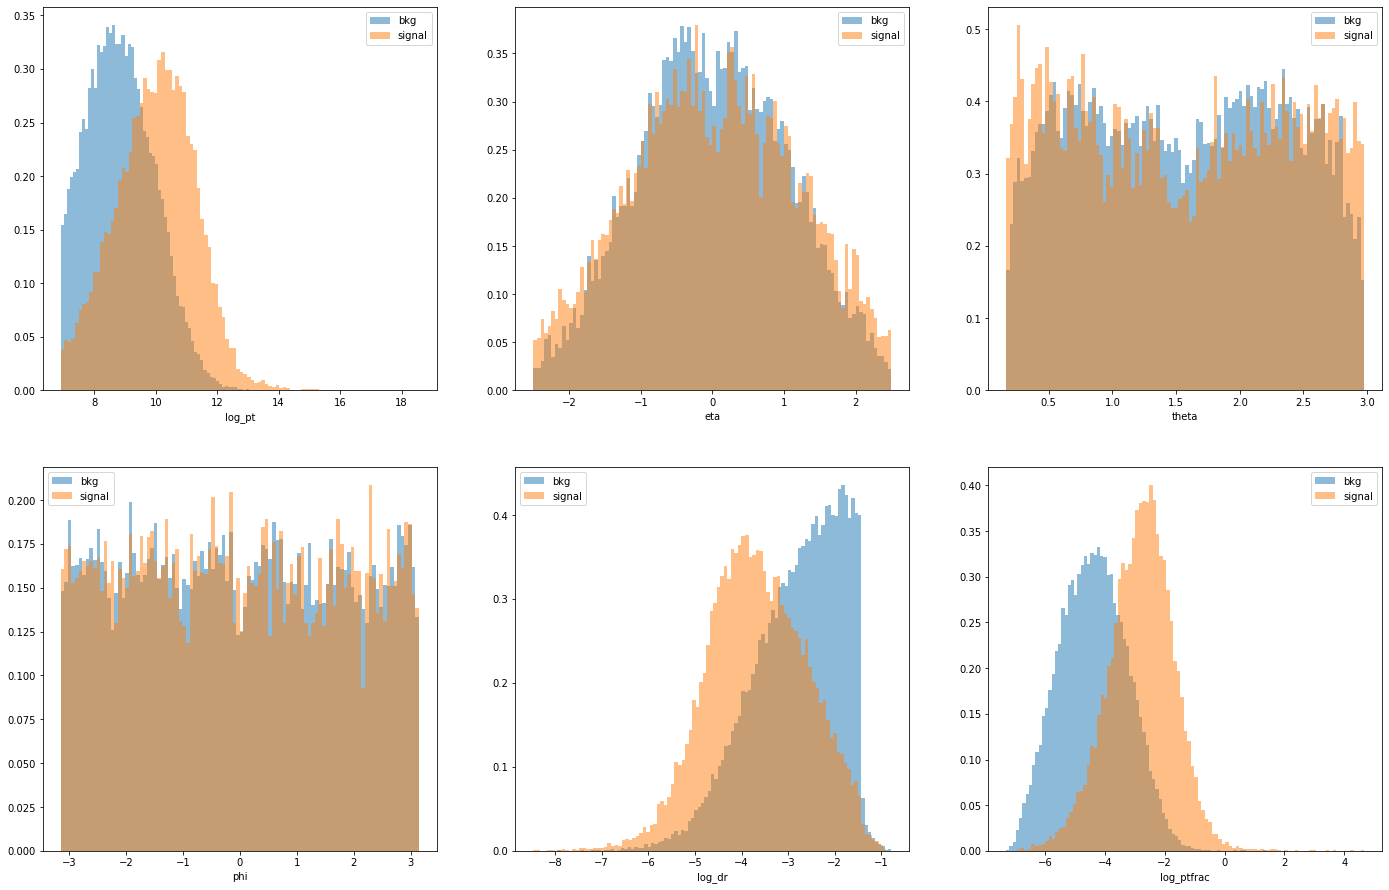

In [33]:
mode='nocut'
jet='singleB'
signal,bkg=sig_bkg_selector(data_singleBTrk_prepr_nocut)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.1)
import os

data_out_dir=jet+'Jet'+mode+'/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_singleB, X_train_singleB_scaled, X_test_singleB, X_test_singleB_scaled, y_train_singleB, y_train_singleB_cat, y_test_singleB, y_test_singleB_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_singleB,y_train_singleB,columns_list,True,'',path+data_out_dir)

bkg size:  (45130, 6) ; signal size:  (20650, 6) ; S/B ratio:  0.45756702858409043
new bkg size:  (45130, 6) ; new signal size:  (20650, 6) ; new S/B ratio:  0.45756702858409043
../PKL/ZprimeVariableCone_m/singleBJetisfromBDinDRcone_notaus/ already exists
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/singleBJetisfromBDinDRcone_notaus/


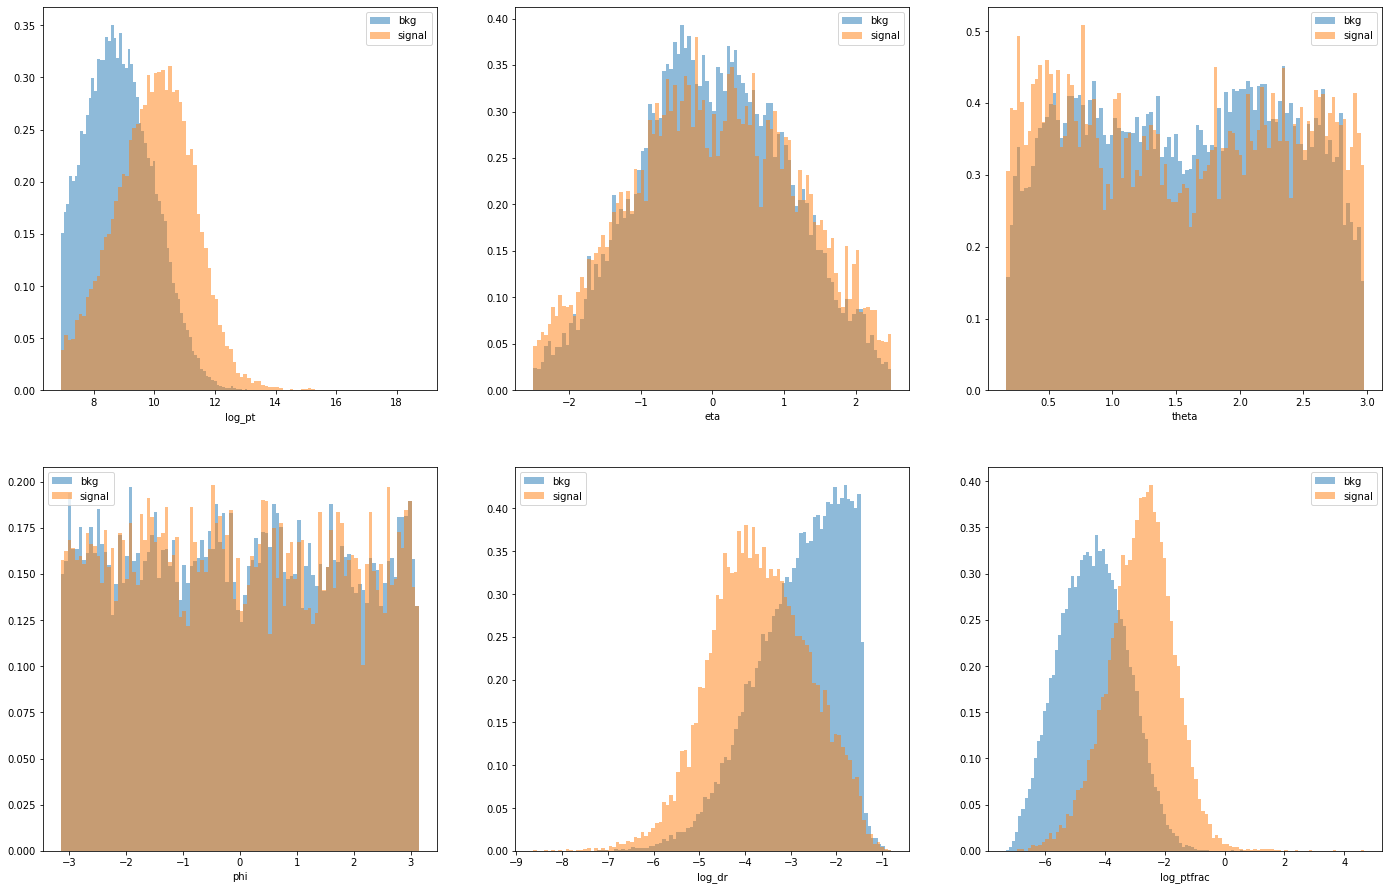

In [34]:
mode='isfromBDinDRcone_notaus'
jet='singleB'
signal,bkg=sig_bkg_selector(data_singleBTrk_prepr_cut)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.1)
import os

data_out_dir=jet+'Jet'+mode+'/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_singleB, X_train_singleB_scaled, X_test_singleB, X_test_singleB_scaled, y_train_singleB, y_train_singleB_cat, y_test_singleB, y_test_singleB_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_singleB,y_train_singleB,columns_list,True,'',path+data_out_dir)

bkg size:  (202287, 6) ; signal size:  (235, 6) ; S/B ratio:  0.0011617157800550702
new bkg size:  (202287, 6) ; new signal size:  (235, 6) ; new S/B ratio:  0.0011617157800550702
created:  ../PKL/ZprimeVariableCone_m/lightJet/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/lightJet/


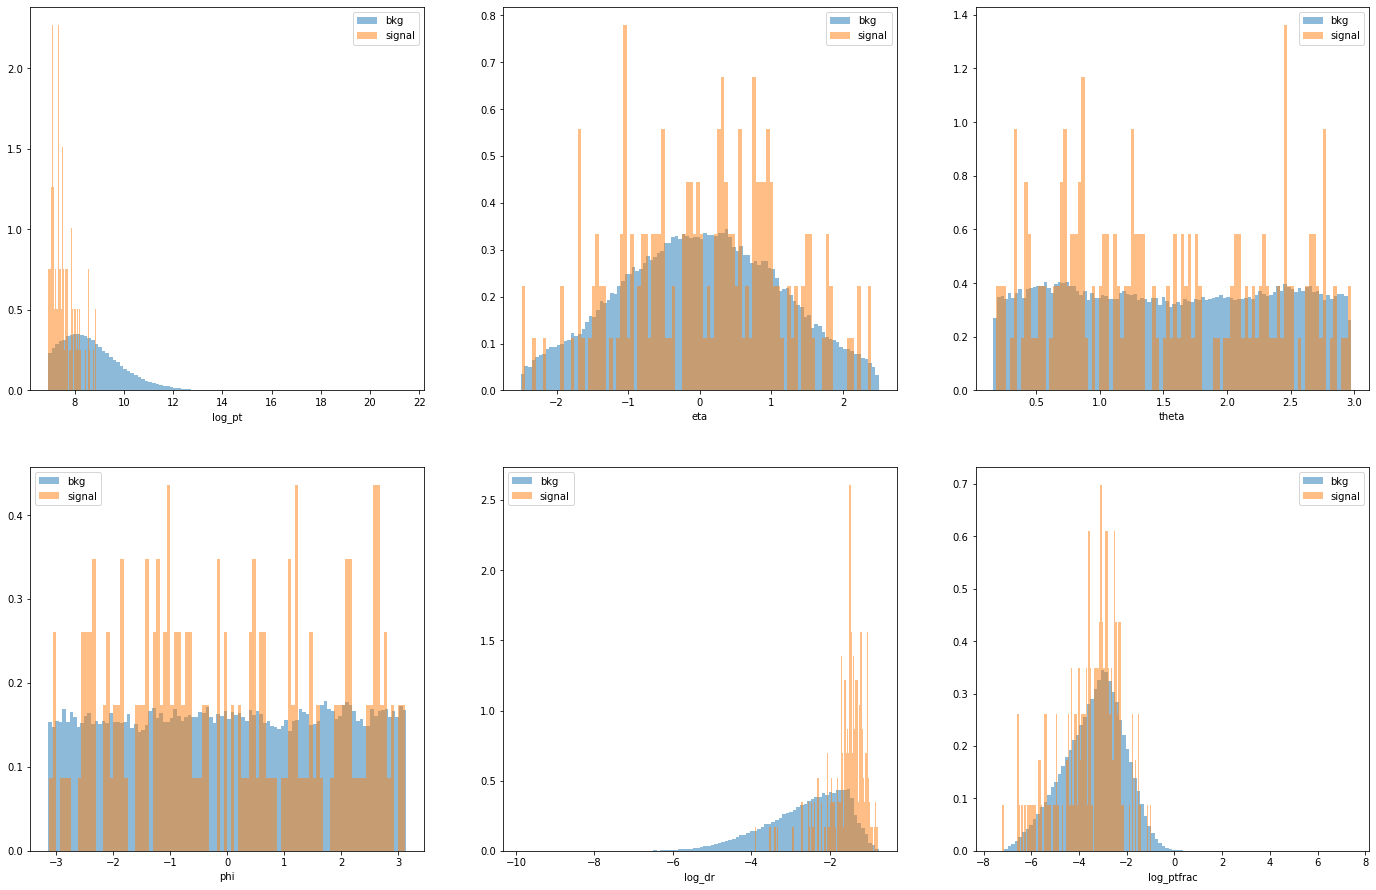

In [32]:
jet='light'
signal,bkg=sig_bkg_selector(data_lightTrk_prepr)
X,y=dp_f.Sig_to_Bkg_eq(signal,bkg,0.00001)

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_light, X_train_light_scaled, X_test_light, X_test_light_scaled, y_train_light, y_train_light_cat, y_test_light, y_test_light_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_light,y_train_light,columns_list,True,'',path+data_out_dir)


bkg size:  (45130, 6) ; signal size:  (20928, 6) ; S/B ratio:  0.4637270108575227
bkg size:  (202287, 6) ; signal size:  (235, 6) ; S/B ratio:  0.0011617157800550702
new bkg size:  (202287, 6) ; new signal size:  (20928, 6) ; new S/B ratio:  0.10345696955315963
created:  ../PKL/ZprimeVariableCone_m/mixedJet/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/mixedJet/


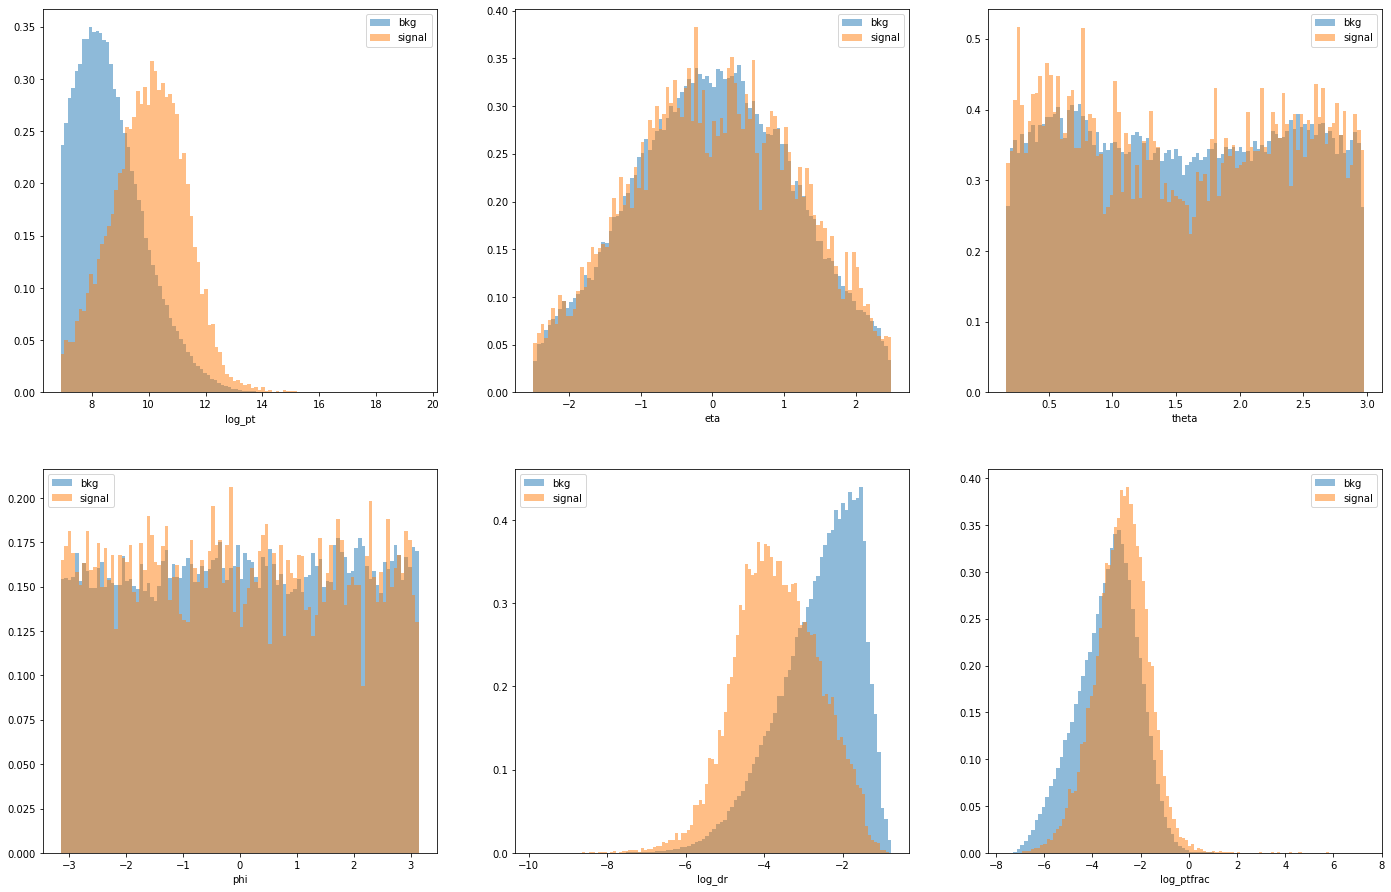

In [19]:
jet='mixed'
signal_singleB,bkg_singleB=sig_bkg_selector(data_singleBTrk_prepr)
signal_light,bkg_light=sig_bkg_selector(data_lightTrk_prepr)

X,y=dp_f.Sig_to_Bkg_eq(signal_singleB,bkg_light,0.01)

import os

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_mixed, X_train_mixed_scaled, X_test_mixed, X_test_mixed_scaled, y_train_mixed, y_train_mixed_cat, y_test_mixed, y_test_mixed_cat=dp_f.dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_mixed,y_train_mixed,columns_list,True,'',path+data_out_dir)


bkg size:  (45130, 6) ; signal size:  (20928, 6) ; S/B ratio:  0.4637270108575227
new bkg size:  (45130, 6) ; new signal size:  (20928, 6) ; new S/B ratio:  0.4637270108575227
created:  ../PKL/ZprimeVariableCone_m/wrongscalingJet/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/wrongscalingJet/


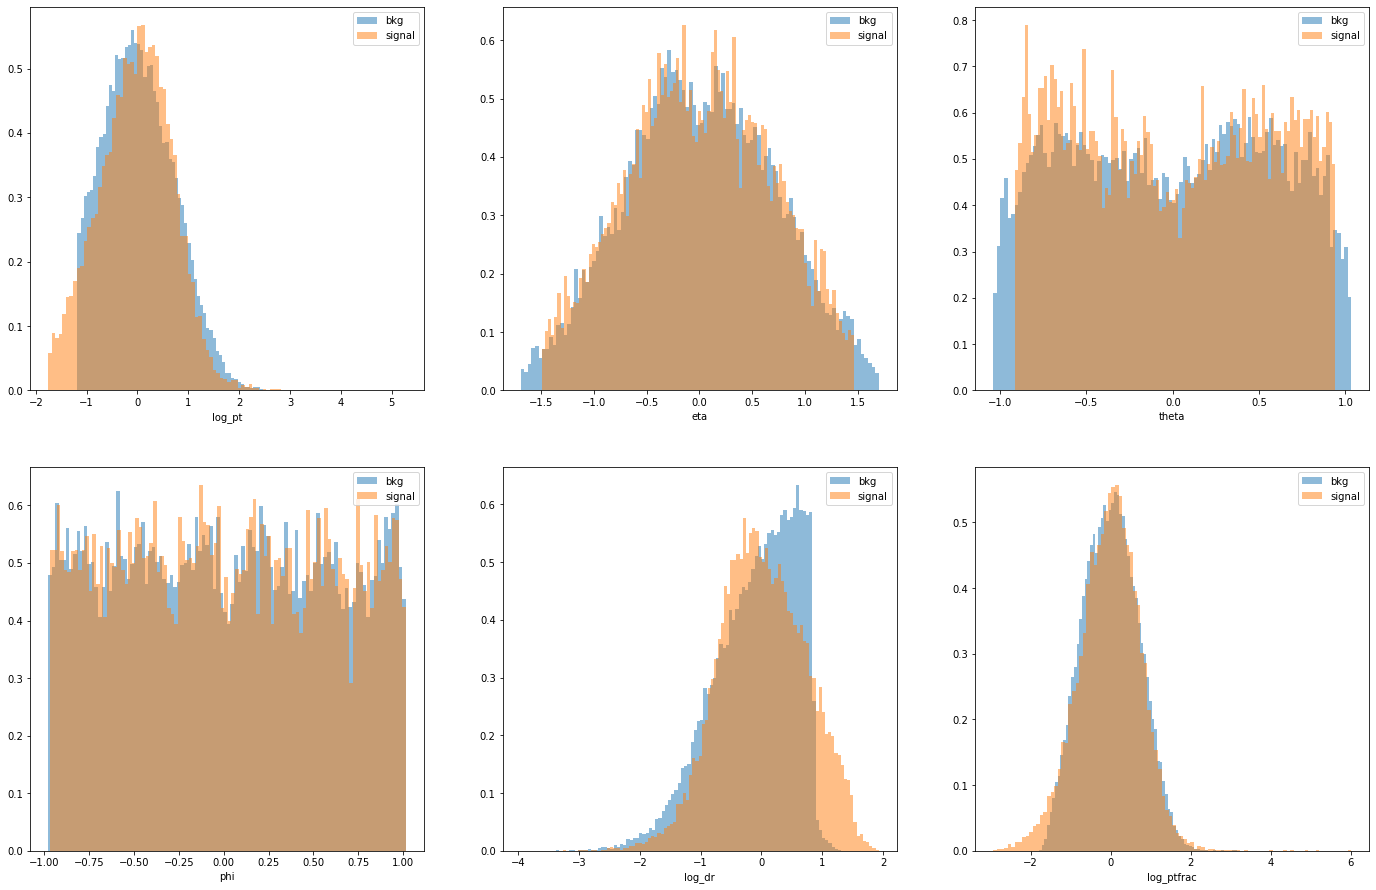

In [12]:
jet='wrongscaling'
signal_singleB,bkg_singleB=sig_bkg_selector(data_singleBTrk_prepr)
X,y=dp_f.Sig_to_Bkg_eq(signal_singleB,bkg_singleB,0.01)

import os

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_scaled, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_scaled,y_train,columns_list,True,'',path+data_out_dir)


In [10]:
jet='mixed_wrongscaling'
signal_singleB,bkg_singleB=sig_bkg_selector(data_singleBTrk_prepr)
signal_light,bkg_light=sig_bkg_selector(data_lightTrk_prepr)

r=0.6
bkg_light=bkg_light[:(int(signal_singleB.shape[0]*(1/r)))]

bkg size:  (45130, 6) ; signal size:  (20928, 6) ; S/B ratio:  0.4637270108575227
bkg size:  (202287, 6) ; signal size:  (235, 6) ; S/B ratio:  0.0011617157800550702


new bkg size:  (34880, 6) ; new signal size:  (20928, 6) ; new S/B ratio:  0.6
created:  ../PKL/ZprimeVariableCone_m/mixed_wrongscalingJet/
saved: X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat
in:  ../PKL/ZprimeVariableCone_m/mixed_wrongscalingJet/


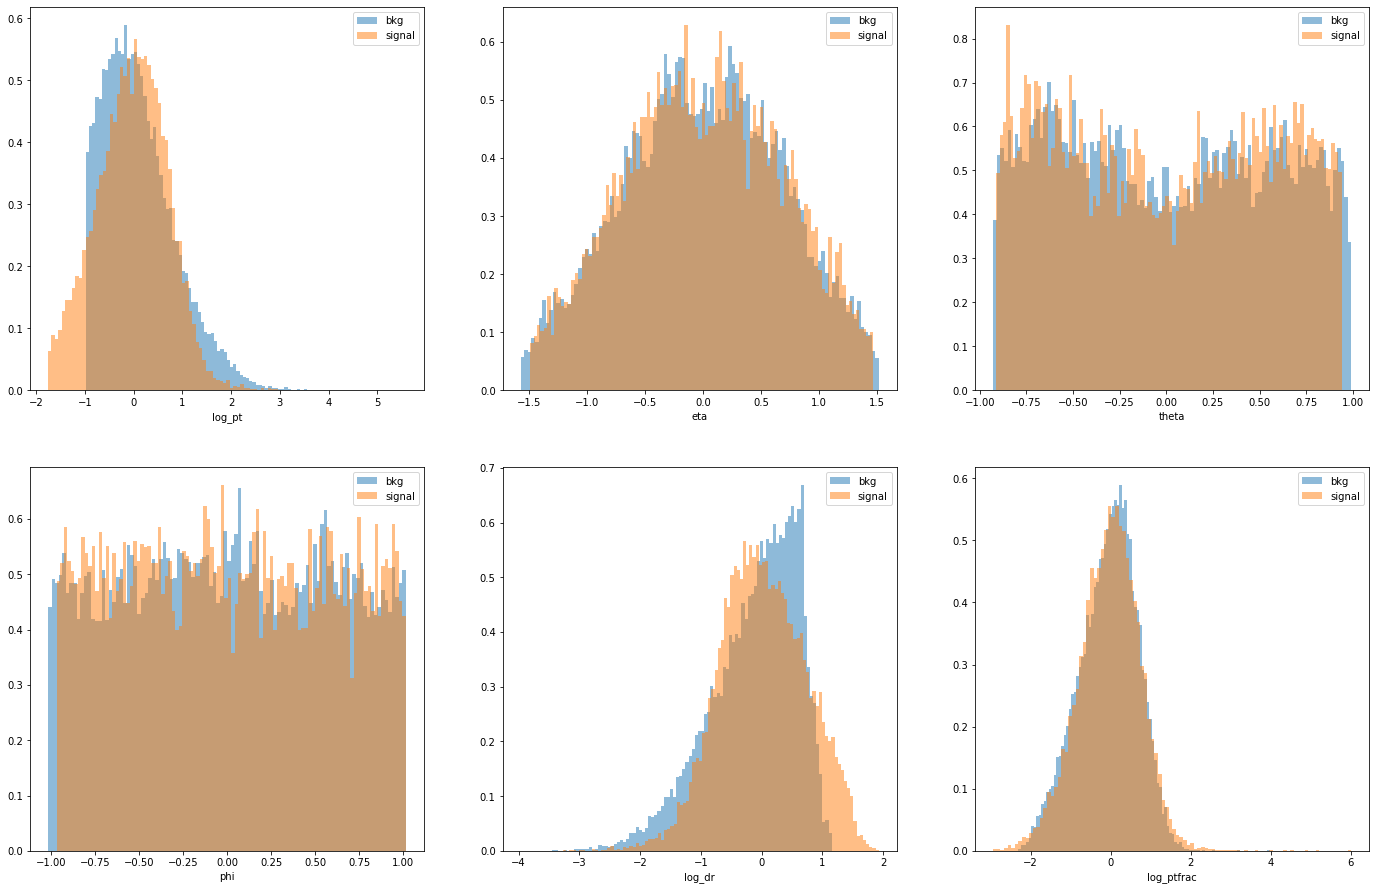

In [11]:
X,y=dp_f.Sig_to_Bkg_eq(signal_singleB,bkg_light,0.01)

import os

data_out_dir=jet+'Jet/'
if not os.path.isdir(path+data_out_dir):
    os.mkdir(path+data_out_dir)
    print('created: ',path+data_out_dir)
else:
    print(path+data_out_dir,'already exists')
    
X_train_scaled, X_test_scaled, y_train, y_train_cat, y_test, y_test_cat=dataset_split(X,y,0.2,path+data_out_dir)
plot_sig_bkg(X_train_scaled,y_train,columns_list,True,'',path+data_out_dir)
